In [371]:
import jax.numpy as jnp
import jax.random as jrandom


import sys 
import os 
HOME = os.getenv("HOME")
sys.path.append(HOME + "/curr_adventure/exact_sampling/")
sys.path.append(HOME + "/curr_adventure/exact_sampling/Optimization")

from Optimization import BFGS, NewtonMethod, GradientDescent, Trust
from pdfo import newuoa

from NEWUO_test import NEWUOA_Wrapper

from pow_sampling_set import pow_SG
from Functions import PyCutestGetter, Quadratic, HeartDisease
from AdaptiveFD import adapt_FD
from FD import FD

from pow_sampling_set import create_approx_S_multi

from tqdm import tqdm

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [384]:
D = jnp.array([0.9987964, 0.89059393, 3.23372579, 10.52481486])


create_approx_S_multi(jnp.diag(D), sig=1, max_h=0.5, pool=None)

[18.07223616  2.21604402  1.2315875   0.68266814]
[0.5        0.5        0.5        0.45772153]
[ 0.89059393  0.9987964   3.23372579 10.52481486]


DeviceArray([[ 0.25      , -0.25      ,  0.25      , -0.25      ],
             [ 0.25      ,  0.25      ,  0.25      ,  0.25      ],
             [ 0.25      ,  0.25      , -0.25      , -0.25      ],
             [ 0.22886076, -0.22886076, -0.22886076,  0.22886076]],            dtype=float64)

In [25]:
dim = 32
Q = jnp.diag(jnp.logspace(-2, 4, dim))
b = jnp.zeros(dim)
sig = 1

x_0 = jnp.ones(dim)/2



In [61]:
H = F.f2(x_0)
res = []
for k in tqdm(jnp.linspace(1, dim*dim, 4)):
    sig = 2
    F = Quadratic(Q, b, sig=sig, noise_type="uniform")


#     F = HeartDisease(sig, noise_type="uniform")
#     x_0 = jnp.array([-0.00549042, -0.83499842,  0.90540353, -0.35528798,
#              -0.28677555,  0.06359361,  0.23585258,  0.59582554,
#              -0.49040073, -0.70567094,  0.33217319, -0.85092055,
#              -0.22942091]) + jrandom.normal(jrandom_key, shape=(13,)) * 1


    N = int(dim * k)
    jrandom_key = jrandom.PRNGKey(0)

    X = jrandom.normal(jrandom_key, shape=(dim, N))
    F_vals = []
    for i in range(N):
        jrandom_key, subkey = jrandom.split(jrandom_key)
        F_vals.append(F.f(X[:, i], subkey))
    F_vals = jnp.array(F_vals)
    
    G = get_G(X, F_vals)
 
    res.append(jnp.linalg.norm(G - H)/jnp.linalg.norm(H))
#     jnp.linalg.eigh(G)

100%|████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s]


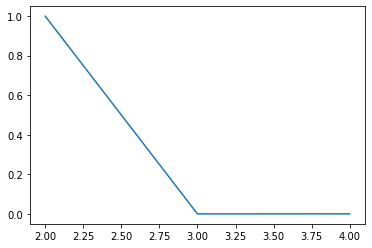

In [62]:
plt.plot(jnp.linspace(1, dim*dim, 4), res)

In [7]:

def create_W(S):
    dim = S.shape[0]
    N = S.shape[1]
    A = 1/2 * (S.T @ S)**2
    eXT = jnp.concatenate([jnp.ones(shape=(N, 1)), S.T], axis=1)
    eTX0 = jnp.concatenate([eXT.T, jnp.zeros(shape=(dim+1, dim+1))], axis=1)
    W = jnp.concatenate([A, eXT], axis=1)
    W = jnp.concatenate([W, eTX0], axis=0)
    return W

def get_G(S, F_vals):
    dim = len(S)

    W = create_W(S)
    F_vals0 = jnp.concatenate([F_vals, jnp.zeros(dim + 1)])
    lcg = jnp.linalg.solve(W, F_vals0)

    lmbda = lcg[:-(dim+1)]

    return S @ jnp.diag(lmbda) @ S.T

      


In [37]:
G = get_G(X, F_vals)
H = F.f2(x_0)
print(jnp.linalg.norm(G - H)/jnp.linalg.norm(H))
jnp.linalg.eigh(G)

2.4549352205142988e-14


(DeviceArray([2.00000000e-02, 3.12304602e-02, 4.87670820e-02,
              7.61509205e-02, 1.18911414e-01, 1.85682909e-01,
              2.89948134e-01, 4.52760682e-01, 7.06996221e-01,
              1.10399086e+00, 1.72390713e+00, 2.69192065e+00,
              4.20349602e+00, 6.56385574e+00, 1.02496118e+01,
              1.60050046e+01, 2.49921828e+01, 3.90258685e+01,
              6.09397914e+01, 9.51588863e+01, 1.48592790e+02,
              2.32031060e+02, 3.62321839e+02, 5.65773887e+02,
              8.83468941e+02, 1.37955708e+03, 2.15421011e+03,
              3.36384865e+03, 5.25272706e+03, 8.20225414e+03,
              1.28080085e+04, 2.00000000e+04], dtype=float64),
 DeviceArray([[ 1.00000000e+00,  4.86783131e-11,  2.04307733e-11, ...,
                1.05339588e-15, -1.27817921e-15,  5.45697367e-16],
              [ 4.86783131e-11, -1.00000000e+00,  1.03647171e-09, ...,
                1.36002321e-15, -5.27355937e-16,  1.33226763e-15],
              [ 2.04307734e-11, -1.036471

In [138]:
G = get_G(X - x_0.reshape(-1, 1), F_vals)
print(jnp.linalg.norm(G - Q)/jnp.linalg.norm(Q))
jnp.linalg.eigh(G)

1.0007848960975605


(DeviceArray([-2.21972998e+01, -2.06935238e+01, -1.90635372e+01,
              -1.68782370e+01, -1.14279403e+01, -5.93895589e+00,
              -3.49491081e+00,  1.39091291e+00,  4.25148608e+00,
               6.24140118e+00,  1.17549176e+01,  1.25880240e+01,
               1.49941481e+01,  1.89119795e+01,  2.13597272e+01,
               2.70292629e+01,  3.23856070e+01,  4.62572996e+01,
               5.17262584e+01,  8.85224293e+01,  1.51073740e+02,
               2.28506644e+02,  3.63578978e+02,  5.66340436e+02,
               8.84131186e+02,  1.38935999e+03,  2.15988076e+03,
               3.36710825e+03,  5.25217898e+03,  8.21157151e+03,
               1.28146509e+04,  2.00030246e+04], dtype=float64),
 DeviceArray([[-3.97122848e-02, -3.01408361e-01,  5.42190380e-01, ...,
               -4.90970297e-05, -3.38306663e-04,  1.89012549e-04],
              [ 1.09114576e-01,  2.27415292e-01,  1.63225649e-01, ...,
                1.04759133e-04,  2.77926092e-04, -4.68367352e-05],
         

 12%|█████████                                                                  | 3/25 [00:00<00:02,  9.20it/s]

H diff 1.001384932700066
H diff 1.000260417572776


 20%|███████████████                                                            | 5/25 [00:00<00:02,  7.94it/s]

H diff 0.9998911371145295
H diff 0.9972502648100198


 28%|█████████████████████                                                      | 7/25 [00:00<00:02,  7.16it/s]

H diff 0.9939800401005706
H diff 0.9963659254532435


 36%|███████████████████████████                                                | 9/25 [00:01<00:02,  6.92it/s]

H diff 0.9949252181297021
H diff 0.9936124033250501


 44%|████████████████████████████████▌                                         | 11/25 [00:01<00:02,  6.90it/s]

H diff 0.9936271030446503
H diff 0.9921344587092116


 52%|██████████████████████████████████████▍                                   | 13/25 [00:01<00:01,  6.29it/s]

H diff 0.9940517198123416
H diff 0.9935127226546112


 60%|████████████████████████████████████████████▍                             | 15/25 [00:02<00:01,  6.58it/s]

H diff 0.9933149121202978
H diff 0.9901279260372663


 68%|██████████████████████████████████████████████████▎                       | 17/25 [00:02<00:01,  6.71it/s]

H diff 0.9886521343338632
H diff 0.9873060041859174


 76%|████████████████████████████████████████████████████████▏                 | 19/25 [00:02<00:00,  6.63it/s]

H diff 0.9881935500262478
H diff 0.9868606988326815


 84%|██████████████████████████████████████████████████████████████▏           | 21/25 [00:03<00:00,  6.18it/s]

H diff 0.9884782138278765
H diff 0.9879814467221503


 92%|████████████████████████████████████████████████████████████████████      | 23/25 [00:03<00:00,  6.48it/s]

H diff 0.9893622136589001
H diff 0.9867414363623149


100%|██████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  6.82it/s]


H diff 0.9854650285743479


100%|██████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.31it/s]


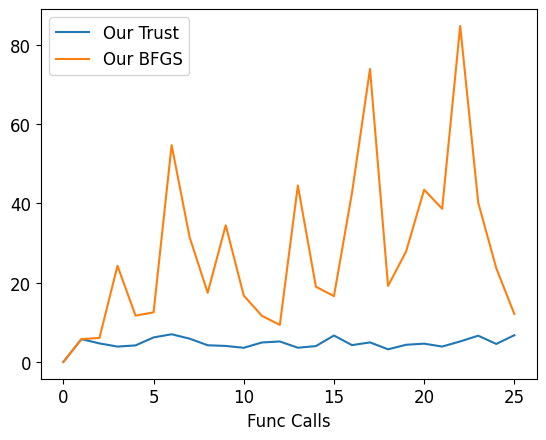

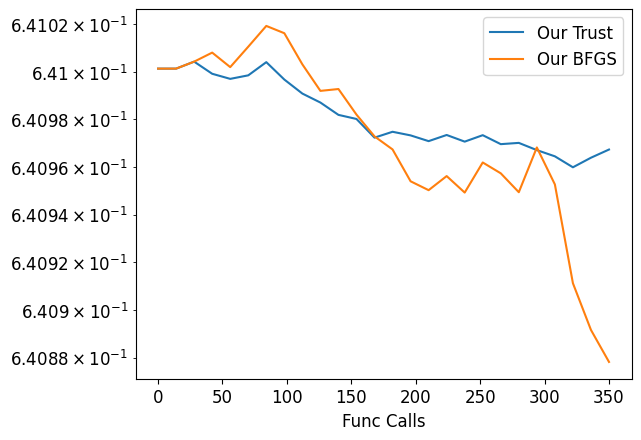

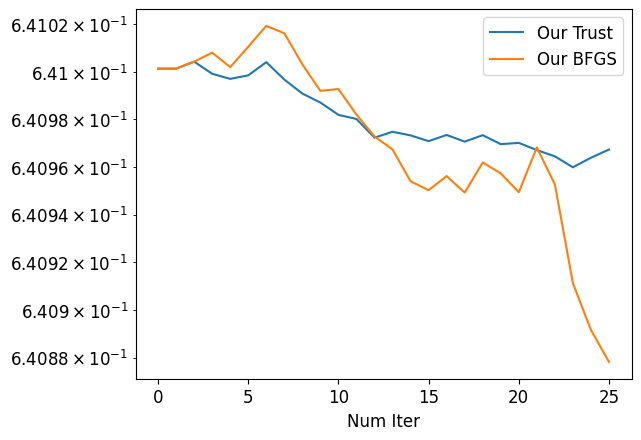

In [328]:
noise_type="uniform"

step_size = 1e-5
num_total_steps = 50
grad_eps = 1e-10
seed = 10

jrandom_key = jrandom.PRNGKey(seed)

dim = 32
Q = jnp.diag(jnp.logspace(-2, 4, dim))
b = jnp.zeros(dim)
sig = 0.1
F = Quadratic(Q, b, sig=sig, noise_type="uniform")

x_0 = jnp.ones(dim)/2

verbose = False
# ----- 
sig = 1
noise_type="uniform"
F = HeartDisease(sig, noise_type)
x_0 = jnp.array([-0.00549042, -0.83499842,  0.90540353, -0.35528798,
             -0.28677555,  0.06359361,  0.23585258,  0.59582554,
             -0.49040073, -0.70567094,  0.33217319, -0.85092055,
             -0.22942091]) + jrandom.normal(jrandom_key, shape=(13,)) * 1

jrandom_key = jrandom.PRNGKey(seed)
# sig = 1
# dim = 32
# Q = jnp.diag(jnp.logspace(-2, 4, dim))
# b = jnp.zeros(dim)
# F = Quadratic(Q, b, sig=sig, noise_type="uniform")

# x_0 = jnp.ones(dim)/2

step_size = 1e-5
num_total_steps = 25
grad_eps = 1e-10
seed = 10

jrandom_key = jrandom.PRNGKey(seed)


# # Our Trust Method
grad_getter = pow_SG(sig, max_h=1)
optimizer = Trust(x_0, F, step_size, num_total_steps, sig, jrandom_key, grad_getter, grad_eps, verbose=verbose)
final_X, our_res, our_X_data = optimizer.run_opt()

# # Our BFGS Method
grad_getter = pow_SG(sig, max_h=1)
optimizer = BFGS(x_0, F, step_size, num_total_steps, sig, jrandom_key, grad_getter, grad_eps, verbose=verbose)
final_X, our_bfgs_res, our_bfgs_X_data = optimizer.run_opt()


plt.plot(range(len(our_res[:, 2])), our_res[:, -1], label="Our Trust")
plt.plot(range(len(our_bfgs_res[:, 2])), our_bfgs_res[:, -1], label="Our BFGS")


plt.xlabel("Func Calls")
# plt.yscale("log")
plt.legend()
plt.show()

plt.plot(our_res[:, 2], our_res[:, 0], label="Our Trust")
plt.plot(our_bfgs_res[:, 2], our_bfgs_res[:, 0], label="Our BFGS")


plt.xlabel("Func Calls")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(range(len(our_res[:, 2])), our_res[:, 0], label="Our Trust")
plt.plot(range(len(our_bfgs_res[:, 2])), our_bfgs_res[:, 0], label="Our BFGS")


# # plt.plot(newuoa_res, label="NEWUOA")
plt.xlabel("Num Iter")
plt.yscale("log")
plt.legend()
plt.show()

In [334]:
jrandom_key = jrandom.PRNGKey(seed)
sig = 2
dim = 32
Q = jnp.diag(jnp.logspace(-2, 4, dim))
b = jnp.zeros(dim)
F = Quadratic(Q, b, sig=sig, noise_type="uniform")
num_total_steps = 20
x_0 = jnp.ones(dim)/dim


# # Our Trust Method
grad_getter = pow_SG(sig, max_h=1)
optimizer = Trust(x_0, F, step_size, num_total_steps, sig, jrandom_key, grad_getter, grad_eps, verbose=verbose)
final_X, our_res, our_X_data = optimizer.run_opt()

100%|██████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.74it/s]


In [284]:
res = []
for i in range(len(optimizer.interp_points.T)):
    x = optimizer.interp_points[:, i]
               
    res.append(F.f(x) - optimizer.F_vals[i])
    

In [285]:
jnp.std(jnp.array(res))

DeviceArray(2.14751966, dtype=float64)

In [286]:
G = get_G(optimizer.interp_points, optimizer.F_vals)
H = F.f2(x_0)
jnp.linalg.norm(G - H)/jnp.linalg.norm(H)

DeviceArray(0.415369, dtype=float64)

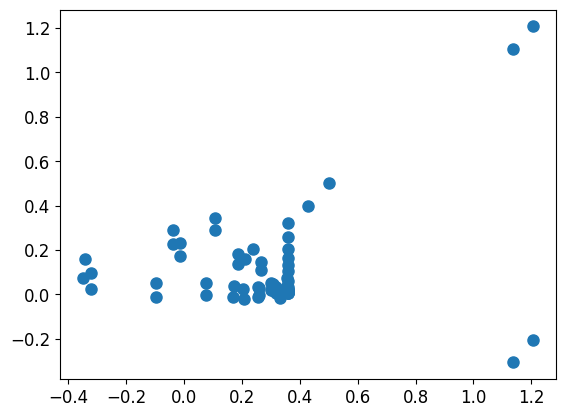

In [92]:
plt.scatter(optimizer.interp_points[0], optimizer.interp_points[1])

In [140]:

F_vals = []
for i in range(len(optimizer.interp_points[0])):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    F = Quadratic(Q, b, sig=0, noise_type="uniform")


    F_vals.append(F.f(optimizer.interp_points[:, i], subkey))
F_vals = jnp.array(F_vals)

G = get_G(optimizer.interp_points, F_vals)

# jnp.linalg.norm(G - H)/jnp.linalg.norm(H)
#     jnp.linalg.eigh(G)

In [93]:
res = []

for i in tqdm(range(optimizer.interp_points.shape[1])):
    for j in range(optimizer.interp_points.shape[1]):
        if i == j:
            continue
        res.append(jnp.linalg.norm(optimizer.interp_points[:, i] - optimizer.interp_points[:, j]))


100%|██████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.02it/s]


In [94]:
min(res)

DeviceArray(0.00055861, dtype=float64)

In [82]:
optimizer.interp_points.shape[1]


660

In [102]:
from scipy.interpolate import Rbf, RBFInterpolator


In [305]:

def _evaluate(x, y, epsilon, coeffs):
    """Evaluate the RBF interpolant at `x`.
    Parameters
    ----------
    x : (Q, N) float ndarray
        Evaluation point coordinates.
    y : (P, N) float ndarray
        Data point coordinates.
    kernel : str
        Name of the RBF.
    epsilon : float
        Shape parameter.
    powers : (R, N) int ndarray
        The exponents for each monomial in the polynomial.
    shift : (N,) float ndarray
        Shifts the polynomial domain for numerical stability.
    scale : (N,) float ndarray
        Scales the polynomial domain for numerical stability.
    coeffs : (P + R, S) float ndarray
        Coefficients for each RBF and monomial.
    Returns
    -------
    (Q, S) float ndarray
    """
    q = x.shape[0]
    p = y.shape[0]

    yeps = y*epsilon
    xeps = x*epsilon
    
    vec = jnp.exp(-jnp.linalg.norm(xeps - yeps, axis=1)**2)

    #         polynomial_vector(xhat[i], powers, vec[p:])
    # Compute the dot product between coeffs and vec. Do not use np.dot
    # because that introduces build complications with BLAS (see
    # https://github.com/serge-sans-paille/pythran/issues/1346)
    out = vec @ coeffs[:-1, 0] + coeffs[-1, 0]

    return out

In [352]:
rbf.powers

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [353]:
from jax import jit, grad, jacfwd

coeffs = jnp.array(rbf._coeffs)
y = jnp.array(rbf.y)
epsilon = rbf.epsilon
curr_x = jnp.array(optimizer.interp_points[:,-1])
H = F.f2(curr_x)
print(_evaluate(curr_x, y, epsilon, coeffs))

rbf_f1 = grad(lambda x: _evaluate(x, y, epsilon, coeffs))
rbf_f2 = jacfwd(lambda x: rbf_f1(x))

jnp.linalg.norm(rbf_f2(curr_x) - H)/jnp.linalg.norm(H)

TypeError: _evaluate() missing 3 required positional arguments: 'shift', 'scale', and 'powers'

In [370]:
rbf = RBFInterpolator(optimizer.interp_points.T, optimizer.F_vals, kernel="gaussian", epsilon=2, smoothing=1)




def _evaluate(x, y, epsilon, coeffs, shift, scale, powers):
    p = y.shape[0]

    yeps = y*epsilon
    xeps = x*epsilon
    xhat = (x - shift)/scale

    r = jnp.linalg.norm(xeps - yeps, axis=1)
    kernel_vec = r**2 * jnp.log(r)
#     kernel_vec = jnp.exp(-r**2) # jnp.nan_to_num(kernel_vec, 0)
    
    poly_vec = jnp.prod(xhat ** powers, axis=1)

    out = kernel_vec @ coeffs[:p, 0] + poly_vec @ coeffs[p:, 0]

    return out

coeffs = jnp.array(rbf._coeffs)
y = jnp.array(rbf.y)
epsilon = rbf.epsilon
shift = jnp.array(rbf._shift)
scale = jnp.array(rbf._scale)
powers = jnp.array(rbf.powers)
curr_x = jnp.array(optimizer.interp_points[:,-1])
H = F.f2(curr_x + 0.1)
print(_evaluate(curr_x, y, epsilon, coeffs, shift, scale, powers))
print(rbf(curr_x.reshape(1, -1)))
print(F.f(curr_x))
Tm
rbf_f1 = grad(lambda x: _evaluate(x, y, epsilon, coeffs, shift, scale, powers))
rbf_f2 = jacfwd(lambda x: rbf_f1(x))

jnp.linalg.norm(rbf_f2(curr_x + 0.1) - H)/jnp.linalg.norm(H)


180.37732945877588
[180.37732946]
2.8104935269224747


DeviceArray(0.94070034, dtype=float64)

In [350]:
coeffs.shape

(693, 1)

In [341]:
jnp.prod(curr_x ** powers, axis=1)

DeviceArray([ 1.00000000e+00, -9.03195889e-01,  3.11397927e-02,
              3.12360946e-02,  3.14232967e-02,  3.12560125e-02,
              3.12564190e-02,  3.12070433e-02,  3.13564939e-02,
              3.11439201e-02,  3.12464495e-02,  3.13399200e-02,
              3.13145103e-02,  3.13801056e-02,  3.13175889e-02,
              3.12243315e-02,  3.11697930e-02,  3.10326842e-02,
              3.09738626e-02,  3.10370692e-02,  3.03998399e-02,
              3.03240257e-02,  2.97882601e-02,  2.90421025e-02,
              2.81102243e-02,  2.64685644e-02,  2.40534811e-02,
              2.05750655e-02,  1.63392569e-02,  1.11251976e-02,
              6.19166197e-03,  2.22919575e-03,  3.60007336e-04],            dtype=float64)

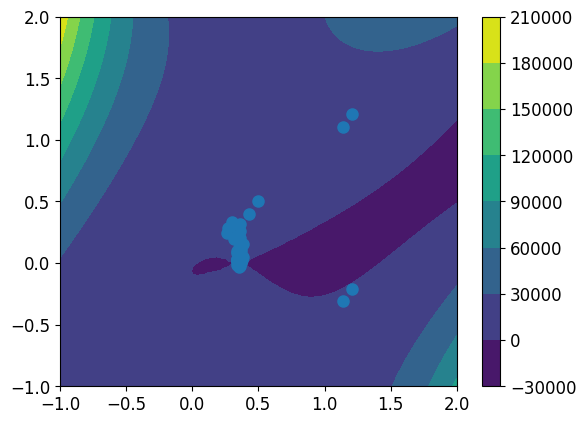

In [303]:
X = jnp.linspace(-1, 2, 100)
X, Y = jnp.meshgrid(X, X)
XY = jnp.vstack([X.ravel(), Y.ravel()])


Z = rbf(XY.T).reshape(X.shape[0], Y.shape[0])
# Z = jnp.diag(XY.T @ G @ XY).reshape(X.shape[0], Y.shape[0])





cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

plt.scatter(optimizer.interp_points[0], optimizer.interp_points[1])

In [161]:
rbf.powers

array([[0, 0]])

In [159]:
rbf._shift

array([0.4281817 , 0.45000815])

In [158]:
rbf._coeffs

array([[-1.88163270e+09],
       [-2.04421645e+09],
       [-5.30700478e+11],
       [ 4.92679708e+09],
       [ 4.16520475e+09],
       [ 9.96431599e+11],
       [-2.49548983e+12],
       [ 4.71130503e+12],
       [ 4.52406891e+12],
       [ 3.67993970e+12],
       [-4.37158091e+12],
       [-1.03174296e+13],
       [-8.45110788e+12],
       [ 9.73702708e+12],
       [ 1.73807087e+12],
       [ 2.62852845e+12],
       [-2.31301844e+12],
       [ 3.98669918e+12],
       [-3.01594057e+11],
       [-3.49287702e+12],
       [ 5.02414409e+12],
       [-2.10644289e+12],
       [-3.50985826e+11],
       [-1.16584728e+11],
       [ 1.88511895e+12],
       [-2.93693502e+12],
       [ 6.63127150e+11],
       [-4.30549347e+10],
       [-2.40769755e+12],
       [-5.42380943e+12],
       [ 6.80012013e+12],
       [ 1.97061577e+12],
       [-2.75110403e+12],
       [ 1.89363292e+12],
       [ 1.41836591e+12],
       [ 2.83422433e+12],
       [-2.65037557e+12],
       [-9.58892241e+11],
       [-3.7

In [180]:
curr_x = optimizer.interp_points[:, -1]

I = jnp.eye(2)

rbf(curr_x.reshape(1, -1))

array([1.72603327e+09])

In [179]:
rbf._coeffs[0][0] = 0

In [171]:
# [0.4281817 , 0.45000815])
rbf._shift[1] = 0

In [172]:
curr_x = optimizer.interp_points[:, -1]

I = jnp.eye(2)

rbf(curr_x.reshape(1, -1))

array([0.21863844])

In [174]:
rbf._scale[0] = 1000